In [ ]:
from time import perf_counter

import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.random as jr
import optax
import equinox as eqx
import diffrax as dfx

from flex import FuzzyVariable
from flex.fiss import TSK
from flex.utils import count_parameters
from flex.utils.types import Array

In [ ]:
# taken from https://docs.kidger.site/diffrax/examples/neural_ode/
# def _get_data(ts, *, key):
#     y0 = jax.random.uniform(key, (2,), minval=-0.6, maxval=1)

#     def f(t, y, args):
#         x = y / (1 + y)
#         return jnp.stack([x[1], -x[0]], axis=-1)

#     solver = dfx.Tsit5()
#     dt0 = 0.1
#     saveat = dfx.SaveAt(ts=ts)
#     sol = dfx.diffeqsolve(
#         dfx.ODETerm(f), solver, ts[0], ts[-1], dt0, y0, saveat=saveat
#     )
#     ys = sol.ys
#     return ys

# def get_data(dataset_size, *, key):
#     ts = jnp.linspace(0, 10, 100)
#     key = jax.random.split(key, dataset_size)
#     ys = jax.vmap(lambda key: _get_data(ts, key=key))(key)
#     return ts, ys

# def dataloader(arrays, batch_size, *, key):
#     dataset_size = arrays[0].shape[0]
#     assert all(array.shape[0] == dataset_size for array in arrays)
#     indices = jnp.arange(dataset_size)
#     while True:
#         perm = jax.random.permutation(key, indices)
#         (key,) = jax.random.split(key, 1)
#         start = 0
#         end = batch_size
#         while end < dataset_size:
#             batch_perm = perm[start:end]
#             yield tuple(array[batch_perm] for array in arrays)
#             start = end
#             end = start + batch_size

In [ ]:
def run_random_traj(ts, *, key):
    y0 = jr.uniform(key, (2,), minval=-0.6, maxval=1.0)

    def f(t, y, args):
        x = y / (y + 1.0)
        return jnp.stack([x[1], -x[0]])

    sol = dfx.diffeqsolve(
        dfx.ODETerm(f),
        dfx.Tsit5(),
        ts[0],
        ts[-1],
        0.1,
        y0,
        saveat=dfx.SaveAt(ts=ts)
    )

    return sol.ys

In [ ]:
def get_data(dataset_size, *, key)

In [3]:
class Func(eqx.Module):
    fis: TSK

    def __init__(
        self,
        n_mfs: int,
        kind: str,
        order: int,
        init_scale: float,
        *,
        key: Array,
        **kwargs,
    ) -> None:
        super().__init__(**kwargs)

        y = (
            FuzzyVariable.ruspini(n_mfs, kind=kind, minval=-1.0, maxval=1.0, name="x"),
            FuzzyVariable.ruspini(n_mfs, kind=kind, minval=-1.0, maxval=1.0, name="xdot")
        )

        self.fis = TSK.init(
            input_vars=y,
            order=order,
            init_scale=init_scale,
            key=key,
            name="FODE",
        )
    
    def __call__(self, t, y, args):
        return self.fis(y).squeeze()  # expecting one output
        

In [4]:
class FuzzyODE(eqx.Module):
    func: Func

    def __init__(
        self,
        n_mfs: int,
        kind: str,
        order: int,
        init_scale: float,
        *,
        key: Array,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.func = Func(
            n_mfs=n_mfs,
            kind=kind,
            order=order,
            init_scale=init_scale,
            key=key,
        )
    
    def __call__(self, ts, y0):
        sol = dfx.diffeqsolve(
            dfx.ODETerm(self.func),
            dfx.Tsit5(),
            t0=ts[0],
            t1=ts[-1],
            dt0=ts[1] - ts[0],
            y0=y0,
            stepsize_controller=dfx.PIDController(rtol=1e-3, atol=1e-6),
            saveat=dfx.SaveAt(ts=ts),
        )

        return sol.ys

In [5]:
dataset_size = 256
batch_size = 64
lr = 1e-2
steps_strategy = (1000, 1000)
length_strategy = (0.1, 1.0)
seed = 12345
print_every = 100

n_mfs = 7
kind = "triangle"
order = 1
init_scale = 0.5

In [6]:
key = jax.random.PRNGKey(seed)
data_key, model_key, loader_key = jax.random.split(key, 3)

ts, ys = get_data(dataset_size, key=data_key)
_, length_size, _ = ys.shape

model = FuzzyODE(
    n_mfs=n_mfs,
    kind=kind,
    order=order,
    init_scale=init_scale,
    key=model_key
)
optim = optax.adam(learning_rate=lr)

In [7]:
@eqx.filter_value_and_grad
def grad_loss(model, ti, yi):
    y_pred = jax.vmap(model, in_axes=(None, 0))(ti, yi[:, 0])
    return jnp.mean((yi - y_pred) ** 2)

@eqx.filter_jit
def make_step(ti, yi, model, opt_state):
    loss, grads = grad_loss(model, ti, yi)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [8]:
for steps, length in zip(steps_strategy, length_strategy):
    opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))
    _ts = ts[: int(length_size * length)]
    _ys = ys[:, : int(length_size * length)]
    for step, (yi,) in zip(
        range(steps), dataloader((_ys,), batch_size, key=loader_key)
    ):
        start = perf_counter()
        loss, model, opt_state = make_step(_ts, yi, model, opt_state)
        end = perf_counter()
        if (step % print_every) == 0 or step == steps - 1:
            print(f"Step: {step}, Loss: {loss}, Computation time: {end - start}")

Step: 0, Loss: 0.14374712109565735, Computation time: 7.986178397999993
Step: 100, Loss: 0.047448426485061646, Computation time: 0.01141873200003829
Step: 200, Loss: 0.052433885633945465, Computation time: 0.010793280000029881
Step: 300, Loss: 0.04036326706409454, Computation time: 0.009778442000083487
Step: 400, Loss: 0.03612292557954788, Computation time: 0.009380296000017552
Step: 500, Loss: 0.039945825934410095, Computation time: 0.00921767300008014
Step: 600, Loss: 0.051917340606451035, Computation time: 0.010727342999985012
Step: 700, Loss: 0.03919477015733719, Computation time: 0.011806602999968163
Step: 800, Loss: 0.03206655755639076, Computation time: 0.008416109999984656
Step: 900, Loss: 0.03219177573919296, Computation time: 0.01588279199995668
Step: 999, Loss: 0.043445296585559845, Computation time: 0.010838852999995652
Step: 0, Loss: 0.519802451133728, Computation time: 11.067969417000086
Step: 100, Loss: 0.3669928014278412, Computation time: 0.05121005800003786
Step: 200,

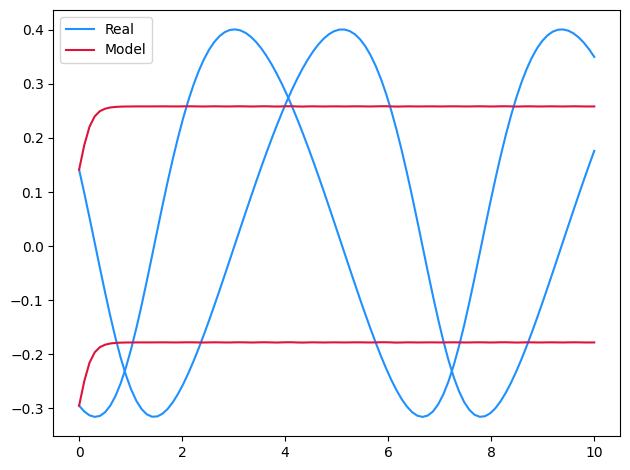

In [9]:
plt.plot(ts, ys[0, :, 0], c="dodgerblue", label="Real")
plt.plot(ts, ys[0, :, 1], c="dodgerblue")
model_y = model(ts, ys[0, 0])
plt.plot(ts, model_y[:, 0], c="crimson", label="Model")
plt.plot(ts, model_y[:, 1], c="crimson")
plt.legend()
plt.tight_layout()
plt.savefig("neural_ode.png")
plt.show()